In [1]:
# Initial Set-Up

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from time import process_time

##### 1.	What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class. 

Inductive reasoning is the reasoning used to make generalizations based on a select number of observations.  This is used often in scientific inquiry. For example, if I wanted to draw conclusions about the migration patterns of ALL starlings, I would have to do that by observing only some of the starlings in the world.  Based on what I see is true for a sample of starlings, I can make statements that are likely to be true for all starlings.

Deductive reasoning is used when an existing generalization is applied to a specific circumstance.  For example, if I know that the trash pick-up in my neighborhood is always on Wednesdays, then I can apply that statement to Wednesday of this week and conclude that the trash will be picked up.  :)

#### Using ONE of the following sources, complete the questions for only that source. 

#### Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29

#### Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 

#### Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.  

#### Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.


##### 2.	Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t. 

In [2]:
# Import data

col_names=['sex','length','diameter','height','whole_weight','shucked_weight','viscera_weight','shell_weight','rings']

abalone_df = pd.read_csv('abalone.data', header = None, names = col_names, delimiter=',')

abalone_df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
# Use one-hot encoding since the sex column has three categories that are not ordinal

# Encode sex column
one_hot = pd.get_dummies(abalone_df['sex'])
abalone_df = abalone_df.drop(['sex'],axis = 1)
abalone_encoded=abalone_df.join(one_hot)
abalone_encoded.head()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,F,I,M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


In [4]:
# Check for null values   --- There are none, so no need to fill or impute missing values.
abalone_encoded.isna().sum()

length            0
diameter          0
height            0
whole_weight      0
shucked_weight    0
viscera_weight    0
shell_weight      0
rings             0
F                 0
I                 0
M                 0
dtype: int64

In [5]:
X=abalone_encoded.drop(['rings'], axis = 1)
y=abalone_df['rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)  

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [6]:
# Examine feature importance

dtr=DecisionTreeRegressor()
dtr.fit(X_train_scaled,y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': dtr.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)

print(importances)

        Attribute  Importance
6    shell_weight    0.491831
4  shucked_weight    0.161835
3    whole_weight    0.089391
5  viscera_weight    0.079485
2          height    0.052944
1        diameter    0.047945
0          length    0.044734
8               I    0.020473
7               F    0.006798
9               M    0.004564


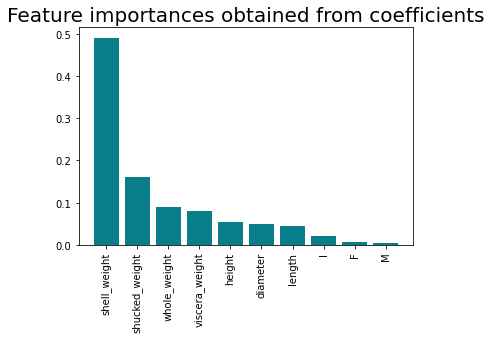

In [7]:
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [8]:
# Drop M and F columns due to low importance

X=abalone_encoded.drop(['rings', 'F', 'M'], axis = 1)
y=abalone_df['rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)  

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

##### 3.	Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

In [9]:
# Without parameter tuning

t1_start = process_time() 
   
dtr = DecisionTreeRegressor(random_state=43)
dtr.fit(X_train_scaled,y_train)
y_pred=dtr.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  2.977319904175941
Processing time =  0.03125


In [10]:
# Using GridSearchCV to tune 3 parameters
# I chose criterion because, frankly, it seemed like it could be an important parameter that may give a variety of results to.
# compare,  I chose max_depth and min_samples_split as well because in my (limited) experience, those parameters have been 
# useful in improving the model.

t1_start = process_time() 

dt_grid = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
           'max_depth': np.arange(5,10),
           'min_samples_split': np.arange(20,50,10)}

model = GridSearchCV(DecisionTreeRegressor(random_state=43), dt_grid, scoring = 'neg_mean_squared_error', cv = 5)
# fit the model
model.fit(X_train_scaled, y_train)

print(model.best_params_)

y_pred = model.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 30}
RMSE =  2.2059957076078973
Processing time =  10.984375


##### 4.	Create a random forest model tuned to the best of your abilities. Explain how you tuned it.

In [11]:
#Without parameter tuning

t1_start = process_time() 

rfr = RandomForestRegressor(random_state=43)
rfr.fit(X_train_scaled,y_train)
y_pred=rfr.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  2.099352087336203
Processing time =  1.015625


In [15]:
# Using RandomizedSearchCV to tune 4 parameters.  I used RandomizedSearchCV in the hopes of cutting down on the overall
# processing time.  I tuned the same three parameters as the Decision Tree, but I wanted to tune the number of trees in the 
# Random Forest as well.  I'm not sure that using RandomSearchCV instead of GridSearchCV made a significant difference in 
# processing time because this cell took substantially more time than the others.  To decide on the parameter ranges, I chose
# ranges that mimic the results I've seen in the few times I have tuned models recently.

t1_start = process_time() 

rf_grid = {'criterion': ['squared_error', 'absolute_error', 'poisson'],
           'n_estimators': np.arange(100,300,100),
           'max_depth': np.arange(3,7,2),
           'min_samples_split': np.arange(10,30,10)}

rfr_model = RandomizedSearchCV(RandomForestRegressor(random_state=43), rf_grid, scoring = 'neg_mean_squared_error', cv = 5)
# fit the model
rfr_model.fit(X_train_scaled, y_train)

print(rfr_model.best_params_)

y_pred = rfr_model.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

{'n_estimators': 100, 'min_samples_split': 10, 'max_depth': 5, 'criterion': 'squared_error'}
RMSE =  2.0826668441897334
Processing time =  117.53125


##### 5.	Create an xgboost model tuned to the best of your abilities. Explain how you tuned it. 

In [13]:
#Without parameter tuning

t1_start = process_time() 

regressor = xgb.XGBRegressor(random_state=43)

regressor.fit(X_train_scaled,y_train)
y_pred = regressor.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

RMSE =  2.2185679143982564
Processing time =  2.96875


In [16]:
# Using GridSearchCV to tune 3 parameters
# I tuned max_depth and n_estimators with this grid search, as well as the learning rate.  Since XGB regressor involves boosting
# I am assuming that the learning rate could have a significant effect on model performance.

t1_start = process_time() 

xgb_grid = {'learning_rate': np.arange(0.01, 0.05, 0.02),
              'max_depth': np.arange(3,7,2),
              'n_estimators': np.arange(100,500,100)}

xgb_model = GridSearchCV(XGBRegressor(random_state=43), xgb_grid, scoring = 'neg_mean_squared_error', cv = 5)
# fit the model
xgb_model.fit(X_train_scaled, y_train)

print(xgb_model.best_params_)

y_pred = xgb_model.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400}
RMSE =  2.0779525032370216
Processing time =  455.453125


##### 6.	Which model performed best? What is your performance metric? Why? 

I ran each of the three models once without any tuning just to get a feel for how they compared with one another in their raw forms.  After that, I used GridSearchCV to optimize a few parameters.  I focused my efforts on just a few parameters for two reasons:  a) I wanted to limit what I examined since I'm new to learning how each of the parameters works, and b) I wanted to make sure that my GridSearchCV did not take an exorbitant amount of time to run.  Despite my efforts, the processing time was pretty high.  I know that with RandomizedSearch I would have likely shortened my processing time in exchange for some loss in RMSE.  But once again, because I'm new to this, I wanted to use the thorough approach of GridSearch.

Without any parameter tuning, the RandomForestRegressor outperformed the other two models with an RMSE of 2.099.  Even after tuning parameters, I was only able to reduce the RMSE by 0.017 to 2.083.  The XBGRegressor model was second best.  Without tuning, the model yielded an RMSE of 2.219.  After tuning three of the parameters, the RMSE decreased to the lowest value of all of the models -- tuned or untuned -- at 2.078.  The DecisionTreeRegressor performed worst, which is expected.  A single decision tree isn't able to produce the level of performance that a forest of multiple trees could.  The RMSE for this model was 2.977 untuned and 2.206 tuned.

I used Root Mean Squared Error as my performance metric because minimizing the error between predicted and actual target values is the most important consideration when the target variable requires regression rather than classification.

### DataCamp 

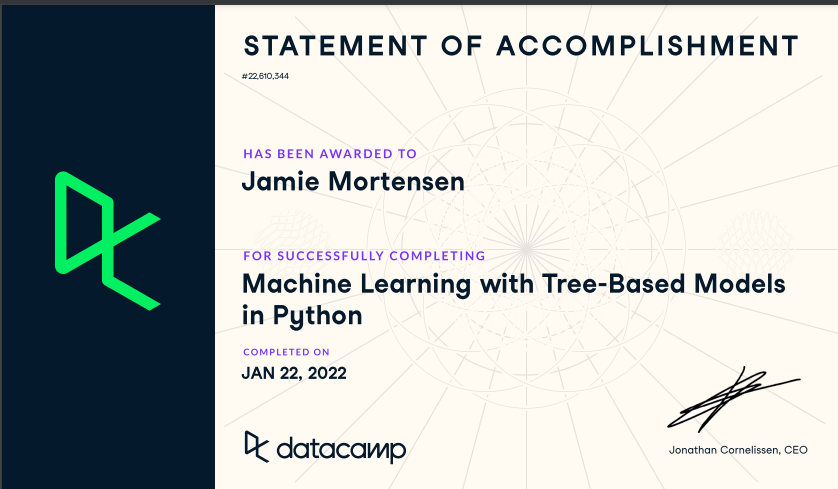